In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
def load_file(path):
    return pd.read_csv(path)

def train_model(model, feature_df, target_df, num_procs, cv_acc,scoring="accuracy"):
    score = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring=scoring)
    cv_acc[model] = np.mean(score)
    
def hyper_parameter_tunning(model,params,hyper_param_acc,best_estimator,feature_values,target_values):
    hyper_param_model=RandomizedSearchCV(model,params,n_jobs=-1,random_state=1, n_iter=100, cv=5,scoring="accuracy")
    hyper_param_model.fit(feature_values,target_values)
    hyper_param_acc[model]=hyper_param_model.best_score_,
    best_estimator[model]=hyper_param_model.best_estimator_
    
def print_hyper_parameter_summary(model,hyper_param_acc):
    print('\nModel:\n', model)
    print('Accuracy during hyper parameter CV:\n', hyper_param_acc[model])
    
def print_summary(model, cv_acc):
    print('\nModel:\n', model)
    print('Accuracy during CV:\n', cv_acc[model])

In [3]:
df_path="./dataset/heart_failure_clinical_records_dataset.csv"
df=load_file(df_path)

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
cat=['anaemia','diabetes','high_blood_pressure','sex','smoking']
num=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
target_var='DEATH_EVENT'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
age                         299 non-null float64
anaemia                     299 non-null int64
creatinine_phosphokinase    299 non-null int64
diabetes                    299 non-null int64
ejection_fraction           299 non-null int64
high_blood_pressure         299 non-null int64
platelets                   299 non-null float64
serum_creatinine            299 non-null float64
serum_sodium                299 non-null int64
sex                         299 non-null int64
smoking                     299 non-null int64
time                        299 non-null int64
DEATH_EVENT                 299 non-null int64
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [7]:
df.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068,0.253729
anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414,0.066270
creatinine_phosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346,0.062728
diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726,-0.001943
ejection_fraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729,-0.268603
high_blood_pressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439,0.079351
platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514,-0.049139
serum_creatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315,0.294278
serum_sodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640,-0.195204
sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608,-0.004316


(13.0, 0.0)

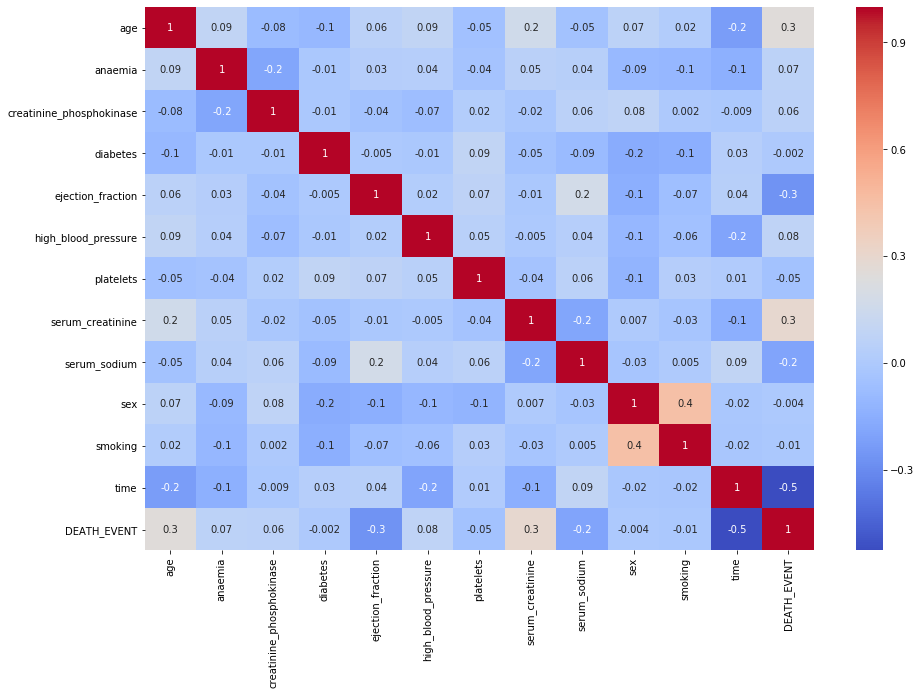

In [8]:
plt.figure(figsize=(15, 10))
ax=sns.heatmap(df.corr(),cmap= 'coolwarm',annot=True,fmt='.1g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [9]:
target=df[target_var]

In [10]:
df.drop(target_var,axis=1,inplace=True)

In [11]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [12]:
X_train,X_test,y_train,y_test=train_test_split(df,target,test_size=0.20, random_state=42,shuffle=True)

In [13]:
num_pipeline=Pipeline([
('imputer', SimpleImputer(strategy="mean")),
('std_scaler', StandardScaler()),
])

cat_pipeline=Pipeline([
('cat_imputer', SimpleImputer(strategy="most_frequent")),
('encoder', OneHotEncoder(handle_unknown="ignore")),
])


In [14]:
full_pipeline = ColumnTransformer([
("num", num_pipeline, num),
("cat", cat_pipeline, cat),
],remainder='passthrough')

In [15]:
X_train_prepared=full_pipeline.fit_transform(X_train)
X_test_prepared=full_pipeline.fit_transform(X_test)

modals=[]
cv_acc = {}
hyper_param_acc={}
best_estimator={}
hyper_parameters=[]

In [16]:
# will try three different models for classification 
#1. K nearest Neighbors 2. Random Forest classifier 3. Logistic regression

knn=KNeighborsClassifier()
logistic=LogisticRegression()
rfClassifier=RandomForestClassifier()
modals.extend([knn,logistic,rfClassifier])

num_procs=4

for modal in modals:
    train_model(modal,X_train_prepared,y_train,num_procs,cv_acc)
    print_summary(modal,cv_acc)


Model:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Accuracy during CV:
 0.7782563025210084

Model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy during CV:
 0.8283263305322128

Model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
           

In [17]:
base_model=max(cv_acc,key=cv_acc.get)
base_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# hyper parameter tuning the all models with randimised search CV
knn_param={
    'n_neighbors': np.arange(1, 25),
    'leaf_size':np.arange(10,100,10),
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree','kd_tree','brute'],
}

logistic_param={
    'penalty':['l2'],
    'C':np.arange(2,100,2),
    'solver':['newton-cg', 'lbfgs', 'liblinear']
}

rf_param={
    'n_estimators':np.arange(100,1000,100),
    'criterion':['gini', 'entropy'],
    'min_samples_split':np.arange(2,10),
    'min_samples_leaf':np.arange(1,10)
}

hyper_parameters.extend([knn_param,logistic_param,rf_param])


for index,modal in enumerate(modals):
    hyper_parameter_tunning(modal,hyper_parameters[index],hyper_param_acc,best_estimator,X_train,y_train)
    print_hyper_parameter_summary(modal,hyper_param_acc)


C:\Users\91887\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Model:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Accuracy during hyper parameter CV:
 (0.7154811715481172,)


C:\Users\91887\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy during hyper parameter CV:
 (0.8661087866108786,)


C:\Users\91887\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy during hyper parameter CV:
 (0.9037656903765691,)


In [19]:
hyper_parameter_model=max(hyper_param_acc,key=hyper_param_acc.get)
final_model=best_estimator.get(hyper_parameter_model)

In [20]:
y_pred=final_model.predict(X_test)
f1_score=f1_score(y_test, y_pred, average='weighted')
print("f1_score of the final Model",f1_score)

score=final_model.score(X_test, y_pred)
score

conf_matrix=confusion_matrix(y_test,y_pred)
conf_matrix

f1_score of the final Model 0.731718898385565


array([[33,  2],
       [13, 12]], dtype=int64)

In [21]:
accuracy_score(y_test, y_pred)

0.75